# Preparation

In [1]:
import torch
import torchvision

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Loading Dataset

In [2]:
from torchvision.datasets import MNIST

train_dataset = MNIST('mnist', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = MNIST('mnist', train=False, transform=torchvision.transforms.ToTensor(), download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 98769204.12it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 103979136.33it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 19498740.84it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15475652.94it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



## Data Generation

In [3]:
from tqdm import trange

def get_false_targets(targets):
    false_targets = targets.clone()
    print('Generating false targets...')
    new_targets = torch.randint(10, (len(targets),))
    for i in trange(len(targets)):
        new_target = new_targets[i].item()
        while new_target == targets[i]:
            new_target = torch.randint(10, (1,)).item()
        false_targets[i] = new_target
    return false_targets

def overlay_label(data, target, classes=10):
    overlayed_data = data.clone()
    overlayed_data[:, :classes] = 0
    overlayed_data[torch.arange(len(data)), target] = 1
    return overlayed_data

# Supervised Training

## Defining Network

\begin{equation*}
loss = \frac{1}{N} log(1 + e^{[(threshold - positivedata), (negativedata - threshold)]})
\end{equation*}
goodness shoud be high for positive datas so $e^{threshold - positivedata}$ is a good loss term.
it also should be low for negative datas so $e^{negativedata - threshold}$ is a good loss term.
combining these two we achieve this result.

In [4]:
class Layer(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(Layer, self).__init__()
        self.fc = torch.nn.Linear(in_features, out_features)
        self.opt = torch.optim.Adam(self.fc.parameters(), lr=5e-2)
        self.threshold = 2
        self.num_epochs = 100

    def forward(self, x):
        x_normal = x / (torch.norm(x, 2, 1, keepdim=True) + 1e-6)
        x = self.fc(x_normal)
        return torch.relu(x)

    def train(self, x_pos, x_neg):
        pbar = trange(self.num_epochs)
        for i in pbar:
            g_pos = torch.mean(self(x_pos) ** 2, 1)
            g_neg = torch.mean(self(x_neg) ** 2, 1)
            loss = torch.mean(torch.log1p(torch.exp(torch.cat([self.threshold - g_pos, g_neg - self.threshold]))))
            pbar.set_description(f'loss: {loss.item():.3f}')
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
        pbar.close()
        return self(x_pos).detach(), self(x_neg).detach()

class SupervisedNet(torch.nn.Module):
    def __init__(self, dims):
        super(SupervisedNet, self).__init__()
        self.layers = []
        for i in range(len(dims) - 1):
            self.layers.append(Layer(dims[i], dims[i+1]).to(device))
        self.num_epochs = 10

    def predict(self, x):
        goodness_per_label = []
        for label in range(10):
            h = overlay_label(x, label)
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness.append(torch.mean(h ** 2, 1))
            goodness_per_label.append(sum(goodness).unsqueeze(1))
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)

    def train(self, x_pos, y):
        for j in range(self.num_epochs):
            print(f'epoch {j + 1}')
            y_neg = get_false_targets(y)
            x_neg = overlay_label(x_pos, y_neg)
            h_pos, h_neg = x_pos, x_neg
            for i, layer in enumerate(self.layers):
                h_pos, h_neg = layer.train(h_pos, h_neg)

## Training

In [5]:
net =  SupervisedNet([784, 500, 500])

X = train_dataset.data
X = X.reshape(X.shape[0], -1).float() / 255.
X = X.to(device)
y = train_dataset.targets.to(device)
X_pos = overlay_label(X, y)

net.train(X_pos, y)

epoch 1
Generating false targets...


loss: 0.669: 100%|██████████| 100/100 [00:04<00:00, 20.03it/s]


epoch 2
Generating false targets...


loss: 0.496: 100%|██████████| 100/100 [00:04<00:00, 20.17it/s]


epoch 3
Generating false targets...


loss: 0.412: 100%|██████████| 100/100 [00:05<00:00, 20.00it/s]


epoch 4
Generating false targets...


loss: 0.357: 100%|██████████| 100/100 [00:04<00:00, 21.61it/s]


epoch 5
Generating false targets...


loss: 0.314: 100%|██████████| 100/100 [00:04<00:00, 21.61it/s]


epoch 6
Generating false targets...


loss: 0.288: 100%|██████████| 100/100 [00:04<00:00, 21.70it/s]


epoch 7
Generating false targets...


loss: 0.267: 100%|██████████| 100/100 [00:04<00:00, 21.89it/s]


epoch 8
Generating false targets...


loss: 0.249: 100%|██████████| 100/100 [00:04<00:00, 22.11it/s]


epoch 9
Generating false targets...


loss: 0.235: 100%|██████████| 100/100 [00:04<00:00, 22.08it/s]


epoch 10
Generating false targets...


loss: 0.226: 100%|██████████| 100/100 [00:04<00:00, 20.67it/s]


## Evaluation

we train the network as instructed in the article using goodness loss. we predict using argmax of most goodness as a class in each layers. we train the network in 10 batches of false data with each being 100 epochs for better generalization.

### Train

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      5923
           1       0.94      0.98      0.96      6742
           2       0.95      0.91      0.93      5958
           3       0.92      0.90      0.91      6131
           4       0.91      0.92      0.92      5842
           5       0.92      0.89      0.90      5421
           6       0.94      0.96      0.95      5918
           7       0.94      0.93      0.93      6265
           8       0.89      0.90      0.90      5851
           9       0.87      0.89      0.88      5949

    accuracy                           0.93     60000
   macro avg       0.93      0.92      0.92     60000
weighted avg       0.93      0.93      0.93     60000



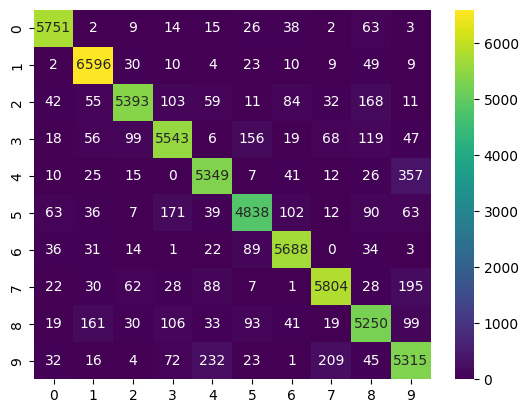

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

X_train = train_dataset.data
X_train = X_train.reshape(X_train.shape[0], -1).float() / 255.
X_train = X_train.to(device)
y_train = train_dataset.targets.to(device)

y_pred = net.predict(X_train)

print(classification_report(y_train.cpu(), y_pred.cpu()))
sns.heatmap(confusion_matrix(y_train.cpu(), y_pred.cpu()), annot=True, fmt='d', cmap='viridis')
plt.show()

### Test

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.94      0.88      0.91      1032
           3       0.90      0.91      0.90      1010
           4       0.91      0.92      0.91       982
           5       0.92      0.88      0.90       892
           6       0.94      0.96      0.95       958
           7       0.93      0.92      0.92      1028
           8       0.87      0.89      0.88       974
           9       0.88      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



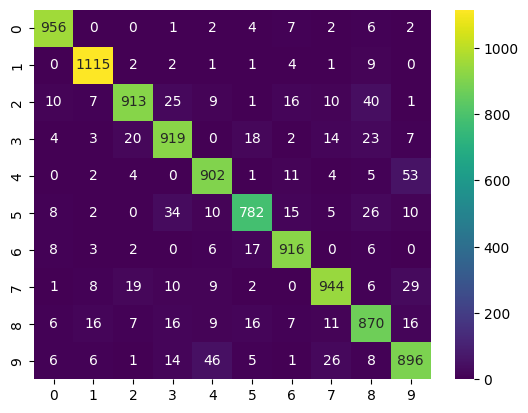

In [7]:
X_test = test_dataset.data
X_test = X_test.reshape(X_test.shape[0], -1).float() / 255.
X_test = X_test.to(device)
y_test = test_dataset.targets.to(device)

y_pred = net.predict(X_test)

print(classification_report(y_test.cpu(), y_pred.cpu()))
sns.heatmap(confusion_matrix(y_test.cpu(), y_pred.cpu()), annot=True, fmt='d', cmap='viridis')
plt.show()

# Unsupervised Training

## Defining Network

We train the network in an unsupervised fashion to detect real numbers from fake numbers.
each layer gives a representation of the inputs and trains to give high goodness for real numbers and low goodness for fake numbers.
during this process with each layer after layer, we get a better representation of the numbers with each number having it's own distribution in the latent space.

In [8]:
class UnsupervisedNet(torch.nn.Module):
    def __init__(self, dims):
        super(UnsupervisedNet, self).__init__()
        self.layers = []
        for i in range(len(dims) - 1):
            self.layers.append(Layer(dims[i], dims[i+1]).to(device))
        self.fc = torch.nn.Linear(dims[-1], 10).to(device)
        self.num_epochs = 100
        self.opt = torch.optim.Adam(self.fc.parameters(), lr=5e-2)

    def train_fc(self, X, y):
        pbar = trange(self.num_epochs)
        for i in pbar:
            h = X
            for layer in self.layers:
                h = layer(h)
            h = h.detach()
            loss = torch.nn.CrossEntropyLoss()(self.fc(h), y)
            pbar.set_description(f'loss: {loss.item():.3f}')
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
        pbar.close()

    def predict(self, x):
        h = x
        for layer in self.layers:
            h = layer(h)
        return self.fc(h).argmax(1)

    def train(self, x_pos, x_negs):
        for j in range(len(x_negs)):
            print(f'epoch {j + 1}')
            h_pos, h_neg = x_pos, x_negs[j]
            for i, layer in enumerate(self.layers):
                h_pos, h_neg = layer.train(h_pos, h_neg)

## Data Generation

In [9]:
def get_blur_mask(shape):
    mask = torch.randint(2, shape).float().unsqueeze(0).to(device)
    filter = torch.tensor([0.25, 0.5, 0.25]).unsqueeze(0).unsqueeze(0).to(device)
    mask = torch.nn.functional.conv1d(mask, filter, padding=1)
    mask = mask.round().bool()
    return mask

def generate_false_data(data):
    false_data = data.clone()
    print('Generating false data...')
    perms = torch.cat([torch.randperm(len(data)), torch.randperm(len(data))])
    mask = get_blur_mask(data.shape[1:]).to(device)
    for i in trange(len(data)):
        first, second = perms[2 * i], perms[2 * i + 1]
        first, second = data[first], data[second]
        false_data[i] = first * mask + second * (~mask)
    return false_data

## Training

Our network's output is the represantion of the numbers in the network's latent space. With enough training and enough layers of processing we get a good enough representation to be seperated by a linear classifier. By training a linear classifier we can test our training process for overfitting and underfitting and check if we have a meaningful representation of our inputs or not.

In [10]:
net =  UnsupervisedNet([784, 500, 500])

X = train_dataset.data
X = X.reshape(X.shape[0], -1).float() / 255.
X = X.to(device)
X_negs = [generate_false_data(X) for _ in range(10)]

net.train(X, X_negs)
net.train_fc(X, y)

Generating false data...


100%|██████████| 60000/60000 [00:05<00:00, 10486.31it/s]


Generating false data...


100%|██████████| 60000/60000 [00:09<00:00, 6408.91it/s]


Generating false data...


100%|██████████| 60000/60000 [00:06<00:00, 9622.14it/s]


Generating false data...


100%|██████████| 60000/60000 [00:07<00:00, 8082.73it/s]


Generating false data...


100%|██████████| 60000/60000 [00:06<00:00, 9585.62it/s] 


Generating false data...


100%|██████████| 60000/60000 [00:06<00:00, 9776.93it/s] 


Generating false data...


100%|██████████| 60000/60000 [00:04<00:00, 13300.30it/s]


Generating false data...


100%|██████████| 60000/60000 [00:03<00:00, 16049.15it/s]


Generating false data...


100%|██████████| 60000/60000 [00:03<00:00, 16196.56it/s]


Generating false data...


100%|██████████| 60000/60000 [00:04<00:00, 12721.21it/s]


epoch 1


loss: 0.624: 100%|██████████| 100/100 [00:04<00:00, 20.73it/s]


epoch 2


loss: 0.582: 100%|██████████| 100/100 [00:04<00:00, 21.21it/s]


epoch 3


loss: 0.528: 100%|██████████| 100/100 [00:04<00:00, 21.33it/s]


epoch 4


loss: 0.477: 100%|██████████| 100/100 [00:04<00:00, 21.49it/s]


epoch 5


loss: 0.441: 100%|██████████| 100/100 [00:04<00:00, 21.32it/s]


epoch 6


loss: 0.398: 100%|██████████| 100/100 [00:04<00:00, 21.37it/s]


epoch 7


loss: 0.385: 100%|██████████| 100/100 [00:04<00:00, 21.75it/s]


epoch 8


loss: 0.354: 100%|██████████| 100/100 [00:04<00:00, 21.83it/s]


epoch 9


loss: 0.330: 100%|██████████| 100/100 [00:04<00:00, 21.93it/s]


epoch 10


loss: 0.401: 100%|██████████| 100/100 [00:02<00:00, 35.37it/s]


## Evaluation

we train the network as instructed in the article using goodness loss. we predict using argmax of fully connected layer with the input being the last layer of representation in our network. we train the network in 10 batches of false data with each being 100 epochs for better generalization. masked data are created as instructed in the article.

### Train

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       980
           1       0.98      0.98      0.98      1135
           2       0.93      0.91      0.92      1032
           3       0.87      0.88      0.88      1010
           4       0.80      0.81      0.81       982
           5       0.85      0.86      0.85       892
           6       0.96      0.95      0.96       958
           7       0.92      0.86      0.89      1028
           8       0.85      0.90      0.87       974
           9       0.76      0.76      0.76      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



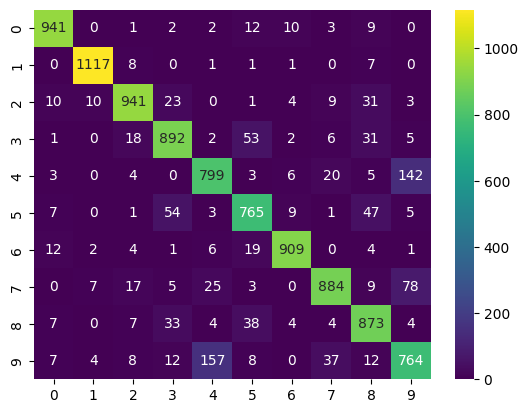

In [11]:
X_train = test_dataset.data
X_train = X_train.reshape(X_train.shape[0], -1).float() / 255.
X_train = X_train.to(device)
y_train = test_dataset.targets.to(device)

y_pred = net.predict(X_train)

print(classification_report(y_train.cpu(), y_pred.cpu()))
sns.heatmap(confusion_matrix(y_train.cpu(), y_pred.cpu()), annot=True, fmt='d', cmap='viridis')
plt.show()

### Test

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       980
           1       0.98      0.98      0.98      1135
           2       0.93      0.91      0.92      1032
           3       0.87      0.88      0.88      1010
           4       0.80      0.81      0.81       982
           5       0.85      0.86      0.85       892
           6       0.96      0.95      0.96       958
           7       0.92      0.86      0.89      1028
           8       0.85      0.90      0.87       974
           9       0.76      0.76      0.76      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



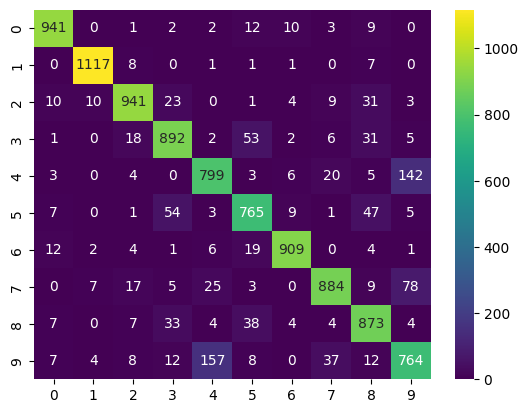

In [12]:
X_test = test_dataset.data
X_test = X_test.reshape(X_test.shape[0], -1).float() / 255.
X_test = X_test.to(device)
y_test = test_dataset.targets.to(device)

y_pred = net.predict(X_test)

print(classification_report(y_test.cpu(), y_pred.cpu()))
sns.heatmap(confusion_matrix(y_test.cpu(), y_pred.cpu()), annot=True, fmt='d', cmap='viridis')
plt.show()